In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip

In [2]:
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
y = np.dot(X, np.array([1, 2])) + 3

In [3]:
class OLS():
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.reg = LinearRegression().fit(self.X, self.y)
        predictions = self.reg.predict(self.X)
        self.df_results = pd.DataFrame({'Actual': self.y, 'Predicted': predictions})
        self.df_results['Residuals'] = abs(self.df_results['Actual']) - abs(self.df_results['Predicted'])
        
    def predict(self, X):
        return self.reg.predict(X)
    
    def results(self):
        print('R^2: {0}'.format(self.reg.score(self.X, self.y)))
    
    def linear_assumption(self):
        df_results = self.df_results
        print("Assumption 1: Linear Relationship exists between the DV and the IV(s).", '\n')
        print("Checking with a scatter plot of actual vs. predicted.",
             'Preditions should follow the diagonal line.')
        
        sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
        line_coords = np.arange(df_results.min().min(), df_results.max().max())
        plt.plot(line_coords, line_coords,
                color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        
    def normal_errors_assumption(self):
        print("Assumption 2: The error terms are normally distributed.", '\n')
        
        print('Using the Anderson-Darling test for normal distribution:')
        
        p_value = normal_ad(self.df_results['Residuals'])[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
        
        if p_value < 0.05:
            print('Residuals are not normally distributed.')
        else:
            print('Residuals are normally distributed.')
            
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(self.df_results['Residuals'])
        plt.show()
        
        if p_value > 0.05:
            print('Assumption satisfied.')
        else:
            print('Assumption not satisfied.')
            print('Confidence intervals will likely be affected.')
            print('Try performing nonlinear transformations on variables.')
            
    def multicollinearity_assumption(self, feature_names=None):
        print("Assumption 3: Little to no multicollinearity among predictors.")
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(pd.DataFrame(self.X, columns=feature_names).corr(), annot=True)
        plt.title('Correlation of Variables')
        plt.show()
        
        print('Variance Inflation Factors (VIF):')
        print('>10: An indication that multicollinearity may be present.')
        print('>100: Certain multicollinearity among the variables.')
        print('------------------------------------')
        
        VIF = [variance_inflation_factor(self.X, i) for i in range(self.X.shape[1])]
        for idx, vif in enumerate(VIF):
            print('{0}: {1}'.format(feature_names[idx], vif))
            
        possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
        definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
        
        print('{0} cases of possible multicollinearity.'.format(possible_multicollinearity))
        print('{0} cases of definite multicollinearity.'.format(definite_multicollinearity))
        
        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied.')
            else:
                print("Assumption possibly satisfied.")
                print('Coefficient interpretability may be problematic.')
                print('Consider removing variables with a high Variance Inflation Factor (VIF).')
                
        else:
            print('Assumption not satisfied.')
            print('Coefficient interpretability will be problematic.')
            print('Consider removing variables with a high Variance Inflation Factor (VIF).')
            
    def autocorrelation_assumption(self):
        print('Assumption 4: No Autocorrelation.', '\n')
        
        print('\nPerforming Durbin-Watson Test...')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data.')
        print('0 to 2 < is positive autocorrelation.')
        print('>2 to 4 is negative autocorrelation.')
        print('---------------------------------------')
        
        durbinWatson = durbin_watson(self.df_results['Residuals'])
        
        print('Durbin-Watson:', durbinWatson)
        
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation.', '\n')
            print('Assumption not satisfied.')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation.', '\n')
            print('Assumption not satisfied.')
        else:
            print('Little to no autocorrelation.', '\n')
            print('Assumption satisfied.')
            
    def homoskedasticity_assumption(self):
        print('Assumption 5: Homoskedasticity of Error Terms.', '\n')
        print('Residuals should have relative constant variance.')
        
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)
        plt.scatter(x=self.df_results.index, y=self.df_results.Residuals, alpha=0.5)
        plt.plot(np.repeat(0, self.df_results.index.max()), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.title('Residuals')
        plt.show()
        
        names = ['Lagrange multiplier statistic', 'p-value',
                'f-value', 'f p-value']
        
        test = het_breuschpagan(self.df_results['Residuals'], self.X)
        
        results = lzip(names, test)
        
        print(results, '\n')
        print(results[1][1])
        
        if results[1][1] >= 0.05:
            print("Because the p-value is not less than 0.05, we fail to reject the null hypothesis.\n")
            print(
                "We do not have sufficient evidence to say that heteroskedasticity is present in the regression model."
            )
            
        else:
            print("Because the p-value is less than 0.05, we reject the null hypothesis in favor of\n")
            print("the alternative hypothesis.\n")
            print("We have sufficient evidence to say that heteroskedasticity is present in the regression model.")
            print("\nWe should try transforming the DV by taking it's log instead or find a new definition of")
            print("the dependent variable. One way to do this would be to take the rate instead of the raw value.")

In [4]:
ols = OLS(X, y)

Assumption 1: Linear Relationship exists between the DV and the IV(s). 

Checking with a scatter plot of actual vs. predicted. Preditions should follow the diagonal line.


C:\Users\Burke Peters\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


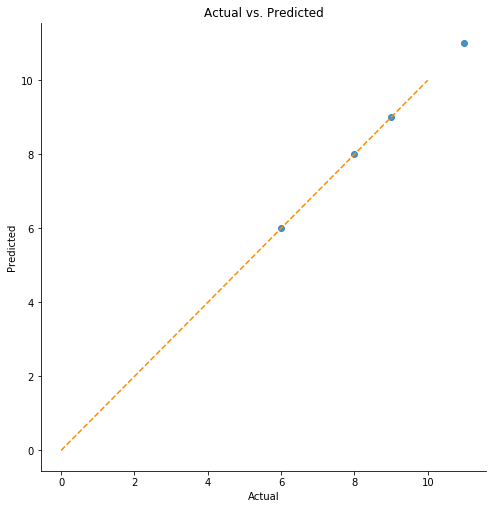

In [5]:
ols.linear_assumption()

Assumption 2: The error terms are normally distributed. 

Using the Anderson-Darling test for normal distribution:
p-value from the test - below 0.05 generally means non-normal: 0.007060970845461353
Residuals are not normally distributed.


C:\Users\Burke Peters\Anaconda3\lib\site-packages\statsmodels\stats\_adnorm.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


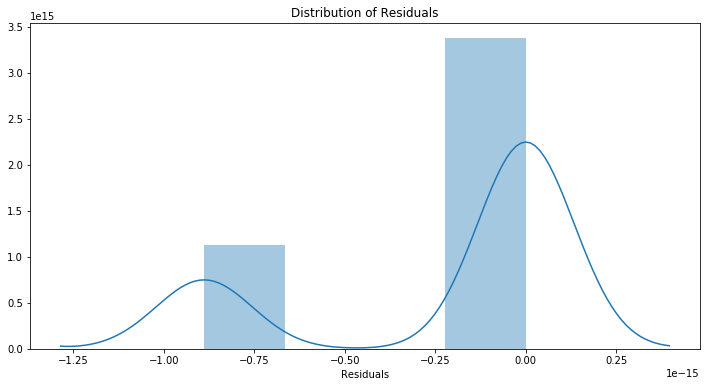

Assumption not satisfied.
Confidence intervals will likely be affected.
Try performing nonlinear transformations on variables.


In [6]:
ols.normal_errors_assumption()

Assumption 3: Little to no multicollinearity among predictors.


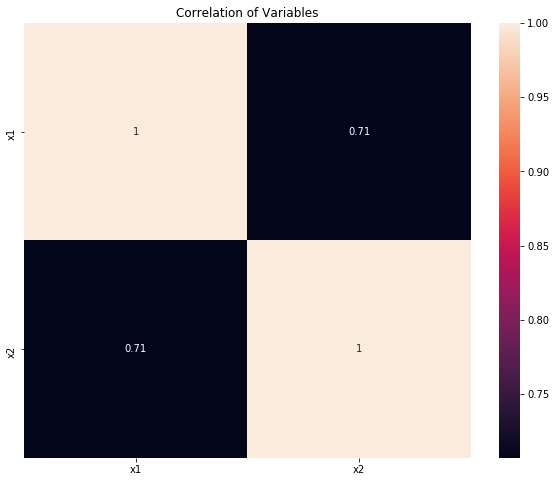

Variance Inflation Factors (VIF):
>10: An indication that multicollinearity may be present.
>100: Certain multicollinearity among the variables.
------------------------------------
x1: 16.363636363636363
x2: 16.363636363636363
2 cases of possible multicollinearity.
0 cases of definite multicollinearity.
Assumption possibly satisfied.
Coefficient interpretability may be problematic.
Consider removing variables with a high Variance Inflation Factor (VIF).


In [7]:
ols.multicollinearity_assumption(['x1', 'x2'])

In [8]:
ols.autocorrelation_assumption()

Assumption 4: No Autocorrelation. 


Performing Durbin-Watson Test...
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data.
0 to 2 < is positive autocorrelation.
>2 to 4 is negative autocorrelation.
---------------------------------------
Durbin-Watson: 1.0
Signs of positive autocorrelation. 

Assumption not satisfied.


Assumption 5: Homoskedasticity of Error Terms. 

Residuals should have relative constant variance.


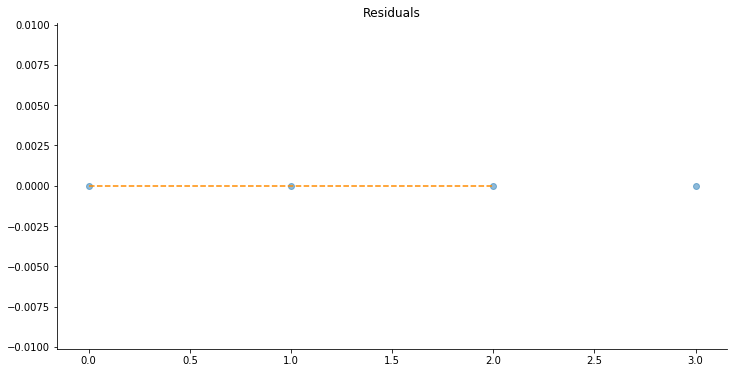

[('Lagrange multiplier statistic', 0.7272727272727271), ('p-value', 0.3937686346429927), ('f-value', 0.22222222222222215), ('f p-value', 0.8181818181818182)] 

0.3937686346429927
Because the p-value is not less than 0.05, we fail to reject the null hypothesis.

We do not have sufficient evidence to say that heteroskedasticity is present in the regression model.


In [9]:
ols.homoskedasticity_assumption()